## Section G. Logistic Regression vs. Bayesian Classifier

### Question 9 [Discriminative vs Generative Models, 25 Marks]

1. Load Task2D_train.csv and Task2D_test.csv as well as the Bayesian classifier (BC) and logistic regression (LR) codes from Activities 2 and 3 in Module 3.

In [32]:
# generates multivariate Gaussian sampels and calculate the densities
library(mvtnorm) 
library(ggplot2)
library(reshape2)

In [33]:
set.seed(12345)

# Load the train and the test set
train <-   read.csv(file = 'Task2D_train.csv', header=TRUE, sep=",")
test <- read.csv(file = 'Task2D_test.csv', header=TRUE, sep=",")

# Split the data into input values and corresponding labels
train.data  <- train[, c('x1', 'x2')]
train.label <- train[,'y']

test.data  <- test[, c('x1', 'x2')]
test.label <- test[,'y']

# class labels
c0 = 1
c1 = -1 

2. Using the first 5 data points from the training set, train a BC and a LR model, and compute their test errors. In a “for loop”, increase the size of training set (5 data points at a time), retrain the models and calculate their test errors until all training data points are used. In one figure, plot the test errors for each model (with different colors) versus the size of the training set.

**Bayesian Classifier**

In [34]:
BC <- function(train.data,train.label,test.data,test.label,train.len){
    
    # Get sample data of 5 indices
    train.index <- sample(1:length(train.label), train.len, replace = FALSE)

    train.data <- train[train.index, c('x1', 'x2')]
    train.label <- train[train.index,'y']
    
    # Class probabilities:
    p0.hat <- sum(train.label== c0)/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- 1 - p0.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])

    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)
    
    # Return the error. Error = sum of incorrect predictions
    error = (sum(test.label!=test.predict)/nrow(test.data)*100)
    return(error)
}

**Logistic Regression**

In [35]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

**Initializing parameters**

In [36]:
LR <- function(train.data, train.label, test.data, test.label, train.len){
  
    #shuffle training data
    train.index <- sample(1:length(train.label), train.len, replace = FALSE)
    train.data <- train[train.index, c('x1', 'x2')]
    train.label <- train[train.index,'y']

    # Initializations
    tau.max <- 1000 # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X)

    # to be used to trace the cost in each iteration
    costs <- data.frame('tau'=1:tau.max) 
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)

    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)

    # the  final result is:
    w <- W[tau,]
    
    # Vector of final weights
    w_vec = c(w)
    
    # vector to store predicted labels
    y_predicted <- c()
    
    for (each in 1:nrow(test.data)){
        
        # Function to predict the label
        res = 1/(1 + exp(1*( w_vec[1] + (w_vec[2]*test.data[each,1]) + (w_vec[3]*test.data[each,2]))))
        
        # If result> 0.5 class = +1 else class=-1        
        if (res>0.5){
          y_predicted[each] = +1
        }
        else{
          y_predicted[each] = -1 
        }
    }
    
    # Calculate the error for every false prediction
    error = 0
    for (val in 1:length(y_predicted)){
        if (y_predicted[val] != test.label[val]){
          error = error + 1
        }
    }
    
    # Return the error
    return((error/nrow(test.data))*100)
    
}

In [37]:
# Vector to store Bayesian errors
BC_error = c()

# Vector to store Logistic regression errors
LR_error = c()

# Steps for every 5 dataframe
step = seq(5,500,5)

for(i in step){
    
    # Calculate the Bayesian error for every 5 data points
    bayesian = BC(train.data, train.label, test.data, test.label,train.len = i)
    
    # Calculate the Logistic error for every 5 data points
    logistic = LR(train.data, train.label, test.data, test.label,train.len = i)
    BC_error = c(BC_error, bayesian)
    LR_error = c(LR_error, logistic)
}

# Error matrix to compare the Bayesian Error and Logistic Error
error_matrix <- data.frame('Step'=step)
error_matrix["Bayesian Error"] = BC_error
error_matrix["Logistic Error"] = LR_error

head(error_matrix)

Step,Bayesian Error,Logistic Error
5,68.4,1.4
10,2.0,1.2
15,1.8,3.8
20,2.4,2.6
25,1.4,1.2
30,1.8,1.4


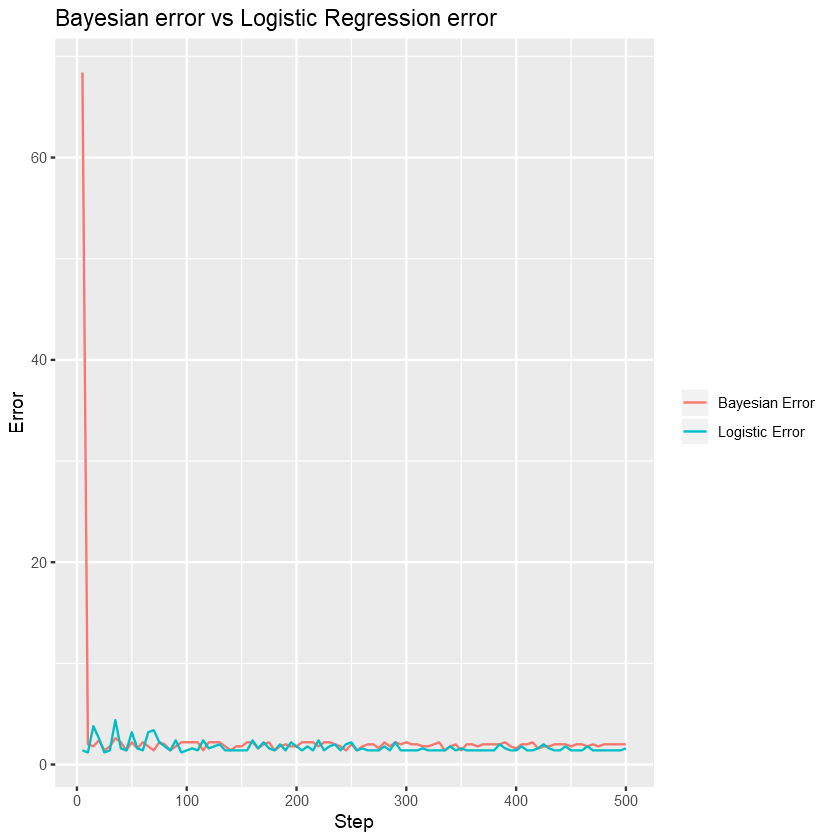

In [38]:
# reshape for visualization
error_matrix.m <- melt(error_matrix, id='Step')
names(error_matrix.m) <- c('Step', 'Type', 'Error')

# plot Bayesian error vs Logistic Regression error graph
ggplot(data=error_matrix.m, aes(x=Step, y=Error, color=Type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) +
       ggtitle("Bayesian error vs Logistic Regression error") + theme_grey()

3. Explain your observations in your Jupyter Notebook file.:

a. What does happen for each classifier when the number of training data points is increased?

**Answer**
* From the graph, it is observed that as the number of data points increases, the error rate of both the classifiers decreases. 

b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?

**Answer**
* Performance of both the models improve with the increase in the number of datasets. However, when the size of the training set is small, Logistic Regression may result in over-fitting. Hence Bayesian Classifier might be a better classifier when the training set is small.

c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons.

**Answer**
* The graph of Bayesian error vs Logistic Regression error shows that the Bayesian error is high initially. However, it converges very quickly as observed from the graph. 
* Logistic Regression requires higher computational resources and it results in initial overfitting which is observed from the graph. However, when the training dataset size increases, performance of Logistic regression is superior to the Bayesian classifier.